# Landau Benchmark

## Environment Definition

In [7]:
import logging

import numpy as np

from do_dpc.control_utils.lti_systems import create_landau_benchmark

# Removes the INFO logging
logging.getLogger().setLevel(logging.WARNING)

noise_config = {"meas_noise_std": np.array([0.005]), "meas_noise_seed": 6473}

env = create_landau_benchmark(**noise_config)

## Training Data Collection

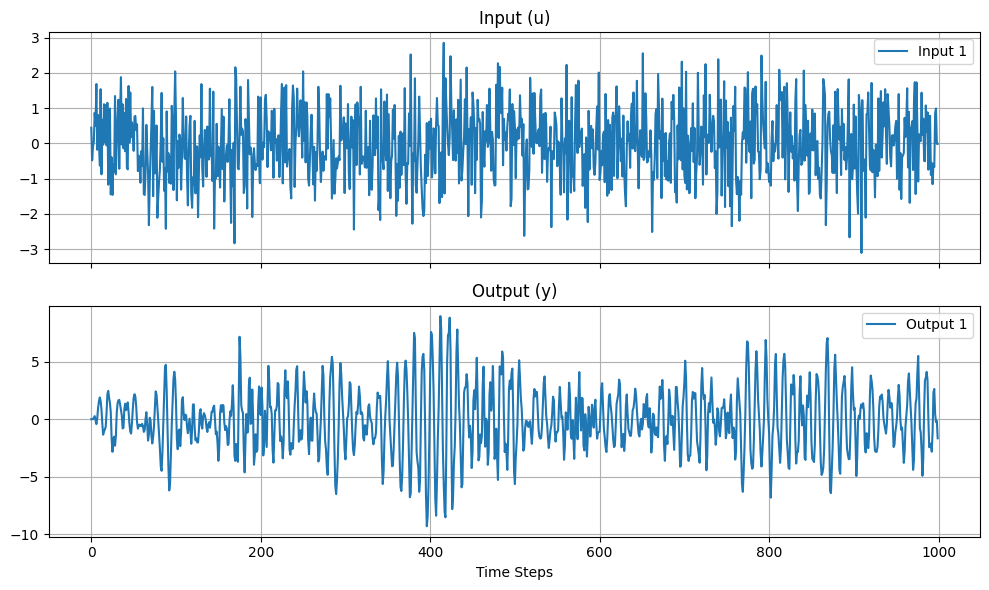

In [8]:
from do_dpc.control_utils.trajectory_collector import collect_trajectory_data
from do_dpc.control_utils.pid_profiles import ONE_D_DOUBLE_INT_PID_COMBO
from do_dpc.utils.plots import plot_training_data

n_samples = 1000

pid_combo = None

_, m, p = env.get_dims()
training_data = collect_trajectory_data(env, m, p, pid_combo)

plot_training_data(training_data)

## Online DPC Application

In [9]:
from tqdm import tqdm
from do_dpc.control_utils.trajectory_collector import TrajectoryCollector
from do_dpc.control_utils.control_structs import Bounds
from do_dpc.dpc.tpc import TPC
from do_dpc.dpc.dpc_structs import DPCParameters

n_sim = 15
traj_col = TrajectoryCollector(m, p, n_sim)
dpc_params = DPCParameters(Q=np.diag([200]), R=0.001 * np.eye(1), tau_p=5, tau_f=20)

ctrl_inst = TPC(dpc_params, training_data)

input_bounds = Bounds(max_values=np.array([10]), min_values=np.array([-20]))
ctrl_inst.add_input_constraints(input_bounds)
ctrl_inst.build_optimization_problem()

y_r = np.array((7,))
u_r = np.zeros((1,))
ctrl_inst.update_tracking_reference(y_r, u_r)

u_next, y_current, y_prev = np.zeros((m,)), env.step(np.zeros((m,))), env.step(np.zeros((m,)))

for _ in tqdm(range(n_sim), desc="Running Simulation", ncols=80):
    traj_col.store_measurements(y_prev, u_next)
    z_p_current = np.concatenate((y_prev, u_next))
    ctrl_inst.update_past_measurements(z_p_current)
    ctrl_inst.solve()
    u_next = ctrl_inst.get_next_control_action()
    y_prev, y_current = y_current, env.step(u_next)

sim_data = traj_col.get_trajectory_data()
print("Running of the DPC algorithm complete")

2025-03-31 11:26:53,620 - WARNING - do_ddpc.ddpc.tpc - Lambda_uu is not positive semidefinite. Regularization cost is skipped to avoid non-convex cost.
Running Simulation: 100%|██████████████████████| 15/15 [00:00<00:00, 152.81it/s]

Running of the DDPC algorithm complete


## Analyse and Data Visualization

All values in u_sim are within the specified bounds.


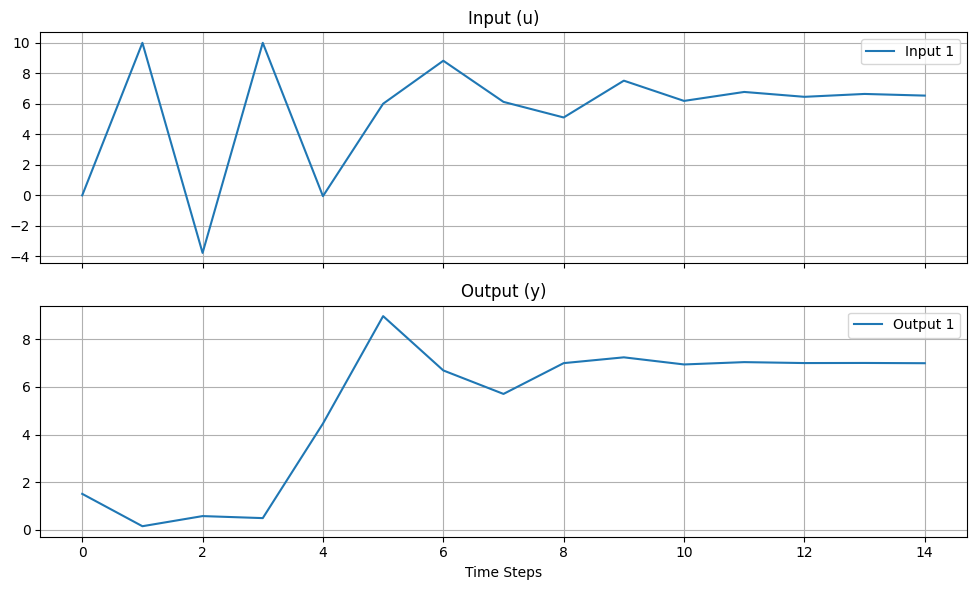

In [10]:
u_sim = sim_data.u
within_bounds = np.all((u_sim >= input_bounds.min_values) & (u_sim <= input_bounds.max_values))

if within_bounds:
    print("All values in u_sim are within the specified bounds.")
else:
    print("Some values in u_sim are out of the specified bounds.")

plot_training_data(sim_data)